In [678]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LassoCV, LassoLarsCV
import time
import random
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [679]:
df = pd.read_csv("nba_data_ready_to_use.csv")
df.shape

(376, 53)

In [680]:
df.head()

,Id,PlayerName,Salary,Age,GP,GS,MP,FG,FGA,FG%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Salary_normalized,Position_encoded,Team_encoded
0,0,Stephen Curry,48070014,4.697012,5.559490,5.559490,4.730817,2.885846,3.873783,0.413080,...,1.194318,7.8,0.192,7.5,0.1,7.5,4.7,17.688169,2,22
1,1,John Wall,47345760,4.597157,4.697012,1.540963,4.017286,1.845581,2.872770,0.351103,...,0.552317,0.3,0.020,-0.8,-0.4,-1.2,0.1,17.672988,2,29
2,2,Russell Westbrook,47080179,4.697012,6.047664,4.137711,4.442813,2.240429,3.300269,0.371862,...,1.412268,1.9,0.044,0.3,-0.1,0.2,1.2,17.667363,2,34
3,3,LeBron James,44474988,4.882973,5.527074,5.494161,4.768768,3.023395,4.017286,0.418049,...,1.343298,5.6,0.138,5.5,0.6,6.1,4.0,17.610438,1,32
4,4,Kevin Durant,44119845,4.697012,5.248357,5.248357,4.773462,2.924479,3.726367,0.459852,...,1.233077,6.8,0.194,6.0,1.2,7.1,3.9,17.602420,1,6


In [681]:
df.columns

Index(['Id', 'PlayerName', 'Salary', 'Age', 'GP', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'TotalMinutes', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%',
       'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48',
       'OBPM', 'DBPM', 'BPM', 'VORP', 'Salary_normalized', 'Position_encoded',
       'Team_encoded'],
      dtype='object')

In [682]:
# Count the datatypes
datatype_counts = df.dtypes.value_counts()

print(datatype_counts)


float64    48
int64       4
object      1
Name: count, dtype: int64


## True predictors selected from this website:

- https://www.bruinsportsanalytics.com/post/nba-ballers 

In [683]:
# true_pred = ['PTS', 'TOV', 'AST', 'VORP', 'PER']
true_pred = df.loc[:, ['PTS', 'TOV', 'AST', 'VORP', 'PER']]
true_pred

,PTS,TOV,AST,VORP,PER
0,4.459352,1.601251,2.316039,4.7,4.144182
1,3.059059,1.343298,2.098648,0.1,3.300269
2,3.521399,1.687259,2.523462,1.2,3.539394
3,4.431709,1.601251,2.405749,4.0,4.131217
4,4.442813,1.630485,2.055642,3.9,4.257079
...,...,...,...,...,...
371,2.352532,0.418049,0.486968,0.1,4.071754
372,1.845581,0.486968,0.418049,-0.2,2.778264
373,1.794654,0.418049,0.673768,-0.3,3.172866
374,1.343298,0.184838,0.836976,0.0,2.872770


In [684]:
base_df = pd.concat([true_pred, df.loc[:, ['Salary_normalized']]], axis=1)

In [685]:
base_df.head()

,PTS,TOV,AST,VORP,PER,Salary_normalized
0,4.459352,1.601251,2.316039,4.7,4.144182,17.688169
1,3.059059,1.343298,2.098648,0.1,3.300269,17.672988
2,3.521399,1.687259,2.523462,1.2,3.539394,17.667363
3,4.431709,1.601251,2.405749,4.0,4.131217,17.610438
4,4.442813,1.630485,2.055642,3.9,4.257079,17.602420


In [686]:
other_pred_df = df.drop(columns=['PTS', 'TOV', 'AST', 'VORP', 'PER', 'Salary', 'Id', 'PlayerName', 'Salary_normalized'])
other_pred_df.head()

,Age,GP,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,Position_encoded,Team_encoded
0,4.697012,5.559490,5.559490,4.730817,2.885846,3.873783,0.413080,2.033680,3.059059,0.365228,...,4.545286,5.8,1.194318,7.8,0.192,7.5,0.1,7.5,2,22
1,4.597157,4.697012,1.540963,4.017286,1.845581,2.872770,0.351103,0.730463,1.601251,0.269993,...,4.322948,-0.4,0.552317,0.3,0.020,-0.8,-0.4,-1.2,2,29
2,4.697012,6.047664,4.137711,4.442813,2.240429,3.300269,0.371862,0.836976,1.794654,0.276365,...,4.363727,-0.6,1.412268,1.9,0.044,0.3,-0.1,0.2,2,34
3,4.882973,5.527074,5.494161,4.768768,3.023395,4.017286,0.418049,1.270788,2.423101,0.284283,...,4.662628,3.2,1.343298,5.6,0.138,5.5,0.6,6.1,1,32
4,4.697012,5.248357,5.248357,4.773462,2.924479,3.726367,0.459852,1.194318,2.033680,0.348109,...,4.529456,4.7,1.233077,6.8,0.194,6.0,1.2,7.1,1,6


In [687]:
total_features_df = base_df
total_features_df

,PTS,TOV,AST,VORP,PER,Salary_normalized
0,4.459352,1.601251,2.316039,4.7,4.144182,17.688169
1,3.059059,1.343298,2.098648,0.1,3.300269,17.672988
2,3.521399,1.687259,2.523462,1.2,3.539394,17.667363
3,4.431709,1.601251,2.405749,4.0,4.131217,17.610438
4,4.442813,1.630485,2.055642,3.9,4.257079,17.602420
...,...,...,...,...,...,...
371,2.352532,0.418049,0.486968,0.1,4.071754,13.139991
372,1.845581,0.486968,0.418049,-0.2,2.778264,13.139991
373,1.794654,0.418049,0.673768,-0.3,3.172866,13.139991
374,1.343298,0.184838,0.836976,0.0,2.872770,13.139991


In [688]:
# Iteratively select random columns and concatenate to base_df
for _ in range(15):
    selected_column_name = random.choice(other_pred_df.columns)
    selected_column = pd.DataFrame(other_pred_df[selected_column_name])
    selected_column.columns = [selected_column_name]  # Ensure the column name is retained
    total_features_df = pd.concat([total_features_df, selected_column], axis=1)
    other_pred_df = other_pred_df.drop(columns=selected_column_name)  # Optionally remove the selected column to avoid repeats

In [689]:
total_features_df

,PTS,TOV,AST,VORP,PER,Salary_normalized,ORB%,FGA,DRB%,FG,...,2P,PF,DWS,FT,3PA,USG%,BLK,TS%,WS/48,3PAr
0,4.459352,1.601251,2.316039,4.7,4.144182,17.688169,1.307510,3.873783,3.601000,2.885846,...,2.077294,1.233077,1.194318,1.965840,3.059059,4.545286,0.345108,0.523977,0.192,0.462590
1,3.059059,1.343298,2.098648,0.1,3.300269,17.672988,1.233077,2.872770,3.059059,1.845581,...,1.571419,1.071059,0.552317,1.307510,1.601251,4.322948,0.345108,0.416631,0.020,0.285072
2,3.521399,1.687259,2.523462,1.2,3.539394,17.667363,1.988790,3.300269,3.574854,2.240429,...,1.988790,1.270788,1.412268,1.478056,1.794654,4.363727,0.418049,0.427225,0.044,0.258762
3,4.431709,1.601251,2.405749,4.0,4.131217,17.610438,1.741928,4.017286,3.918001,3.023395,...,2.736065,1.027379,1.343298,1.965840,2.423101,4.662628,0.486968,0.475515,0.138,0.274775
4,4.442813,1.630485,2.055642,3.9,4.257079,17.602420,0.836976,3.726367,3.820830,2.924479,...,2.648297,1.233077,1.233077,2.352532,2.033680,4.529456,0.935553,0.537582,0.194,0.240902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2.352532,0.418049,0.486968,0.1,4.071754,13.139991,3.484859,1.845581,3.289999,1.307510,...,1.113384,0.982247,0.184838,0.982247,0.935553,4.317051,0.095995,0.521369,0.211,0.296066
372,1.845581,0.486968,0.418049,-0.2,2.778264,13.139991,2.423101,1.571419,2.937163,0.935553,...,0.673768,1.027379,0.345108,0.673768,0.887176,3.310480,0.095995,0.462590,0.065,0.346610
373,1.794654,0.418049,0.673768,-0.3,3.172866,13.139991,3.116900,1.571419,3.494064,1.027379,...,1.027379,1.194318,0.184838,0.486968,0.095995,3.047253,0.552317,0.464640,0.082,0.046088
374,1.343298,0.184838,0.836976,0.0,2.872770,13.139991,1.343298,1.307510,2.602594,0.730463,...,0.614477,0.418049,0.184838,0.184838,0.486968,2.999200,0.095995,0.418049,0.076,0.252298


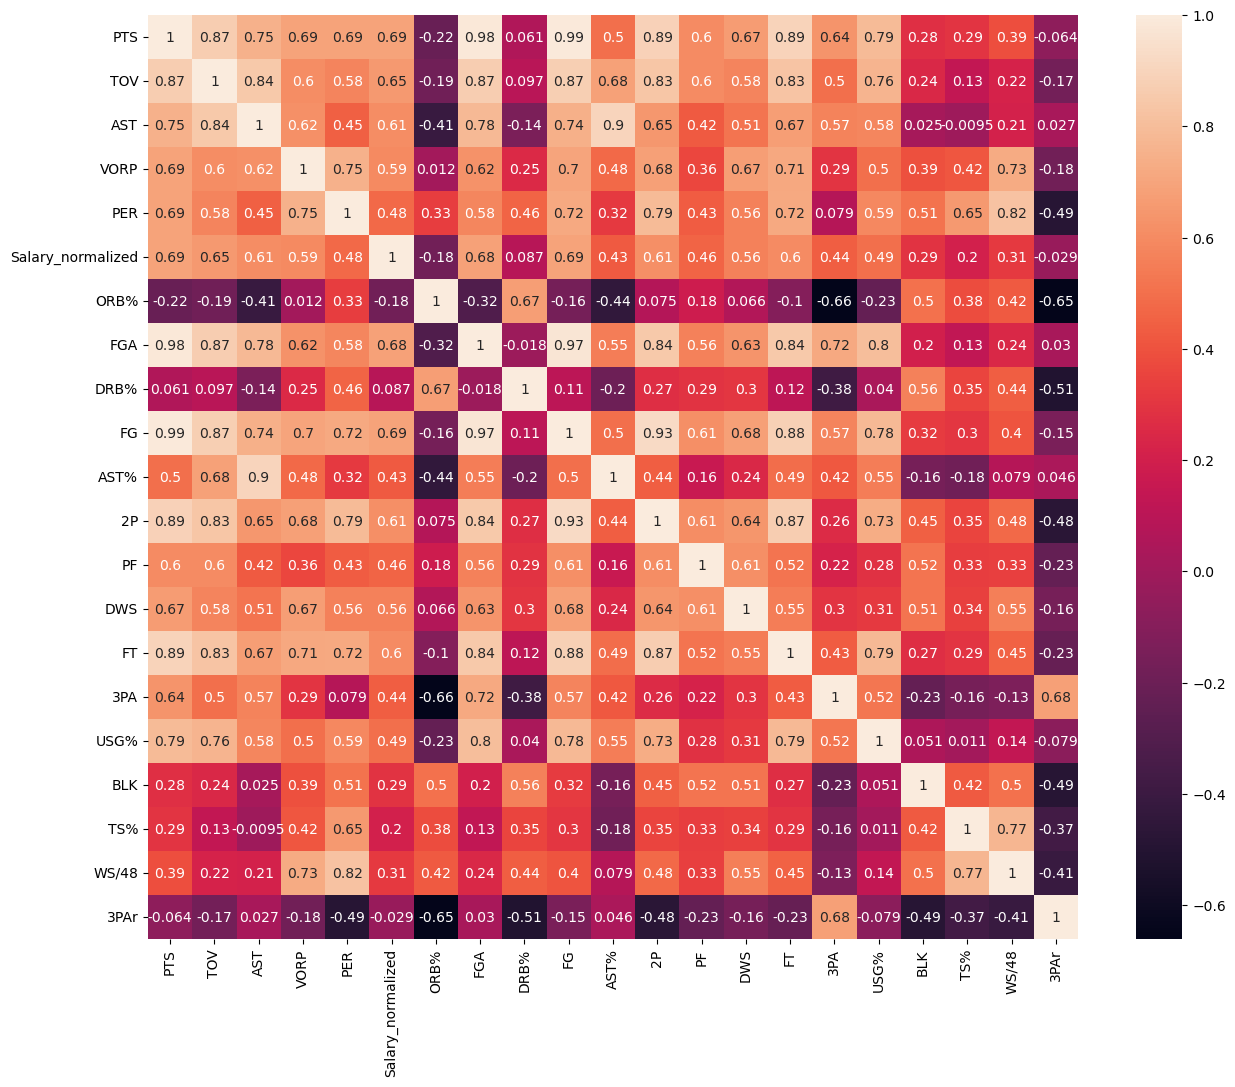

In [690]:
# Exclude non-numeric columns
corrmat = total_features_df.corr()

f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, annot=True);

In [691]:
# Threshold for identifying multicollinearity
threshold = 0.8

# Find pairs of highly correlated features
high_corr_var = {}
for i in range(len(corrmat.columns)):
    for j in range(i):
        if abs(corrmat.iloc[i, j]) > threshold:
            colname = corrmat.columns[i]
            if colname not in high_corr_var:
                high_corr_var[colname] = corrmat.columns[j]

print("Highly correlated features (above threshold of {}):".format(threshold))
for key, value in high_corr_var.items():
    print(key, "<--->", value)

Highly correlated features (above threshold of 0.8):
TOV <---> PTS
AST <---> TOV
FGA <---> PTS
FG <---> PTS
AST% <---> AST
2P <---> PTS
FT <---> PTS
USG% <---> FGA
WS/48 <---> PER


### Multicollinearity in the randomly selected features:

It seems that there is a lot of high multicollinearity in this dataset. because of this, the feature selection of lasso is going to be inconsistent 

## Lasso time

In [692]:
X = total_features_df.drop(['Salary_normalized'], axis=1)
y = total_features_df['Salary_normalized']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [693]:
X

,PTS,TOV,AST,VORP,PER,ORB%,FGA,DRB%,FG,AST%,2P,PF,DWS,FT,3PA,USG%,BLK,TS%,WS/48,3PAr
0,4.459352,1.601251,2.316039,4.7,4.144182,1.307510,3.873783,3.601000,2.885846,4.492018,2.077294,1.233077,1.194318,1.965840,3.059059,4.545286,0.345108,0.523977,0.192,0.462590
1,3.059059,1.343298,2.098648,0.1,3.300269,1.233077,2.872770,3.059059,1.845581,4.759347,1.571419,1.071059,0.552317,1.307510,1.601251,4.322948,0.345108,0.416631,0.020,0.285072
2,3.521399,1.687259,2.523462,1.2,3.539394,1.988790,3.300269,3.574854,2.240429,4.909453,1.988790,1.270788,1.412268,1.478056,1.794654,4.363727,0.418049,0.427225,0.044,0.258762
3,4.431709,1.601251,2.405749,4.0,4.131217,1.741928,4.017286,3.918001,3.023395,4.672512,2.736065,1.027379,1.343298,1.965840,2.423101,4.662628,0.486968,0.475515,0.138,0.274775
4,4.442813,1.630485,2.055642,3.9,4.257079,0.836976,3.726367,3.820830,2.924479,4.169852,2.648297,1.233077,1.233077,2.352532,2.033680,4.529456,0.935553,0.537582,0.194,0.240902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,2.352532,0.418049,0.486968,0.1,4.071754,3.484859,1.845581,3.289999,1.307510,3.105486,1.113384,0.982247,0.184838,0.982247,0.935553,4.317051,0.095995,0.521369,0.211,0.296066
372,1.845581,0.486968,0.418049,-0.2,2.778264,2.423101,1.571419,2.937163,0.935553,1.988790,0.673768,1.027379,0.345108,0.673768,0.887176,3.310480,0.095995,0.462590,0.065,0.346610
373,1.794654,0.418049,0.673768,-0.3,3.172866,3.116900,1.571419,3.494064,1.027379,2.539599,1.027379,1.194318,0.184838,0.486968,0.095995,3.047253,0.552317,0.464640,0.082,0.046088
374,1.343298,0.184838,0.836976,0.0,2.872770,1.343298,1.307510,2.602594,0.730463,3.484859,0.614477,0.418049,0.184838,0.184838,0.486968,2.999200,0.095995,0.418049,0.076,0.252298


In [694]:
lasso = LassoCV(cv=5, random_state=8, max_iter=10000, n_jobs=-1)

lasso.fit(X_train, y_train)

best_alpha = lasso.alpha_
print("Optimal alpha:", best_alpha)

Optimal alpha: 0.01641860350718682


In [695]:
lasso_coefficients = lasso.coef_
lasso_coefficients

array([ 0.36980056,  0.31066794,  0.16958219,  0.11800603, -0.        ,
       -0.08338059,  0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.10643331,  0.3442899 , -0.        ,  0.03605698,
       -0.        ,  0.        ,  0.        , -0.        ,  0.        ])

In [696]:
# Print list of new coefficients of all features
lasso_coefficients_df = pd.DataFrame({'Feature': X.columns, 'LassoCV_Coefficient': lasso_coefficients})
lasso_coefficients_df

,Feature,LassoCV_Coefficient
0,PTS,0.369801
1,TOV,0.310668
2,AST,0.169582
3,VORP,0.118006
4,PER,-0.000000
5,ORB%,-0.083381
6,FGA,0.000000
7,DRB%,0.000000
8,FG,0.000000
9,AST%,-0.000000


In [697]:
# To avoid taking log of zero or negative, add a small constant (epsilon)
epsilon = 1e-10

# Create a DataFrame to compare the coefficients
coefficients_df = pd.DataFrame({
    'Feature_Index': (X.columns),
    'Lasso_Coefficients': lasso_coefficients
})

zero_indices = coefficients_df[coefficients_df['Lasso_Coefficients'] == 0]['Feature_Index']



In [698]:
coefficients_df

,Feature_Index,Lasso_Coefficients
0,PTS,0.369801
1,TOV,0.310668
2,AST,0.169582
3,VORP,0.118006
4,PER,-0.000000
5,ORB%,-0.083381
6,FGA,0.000000
7,DRB%,0.000000
8,FG,0.000000
9,AST%,-0.000000


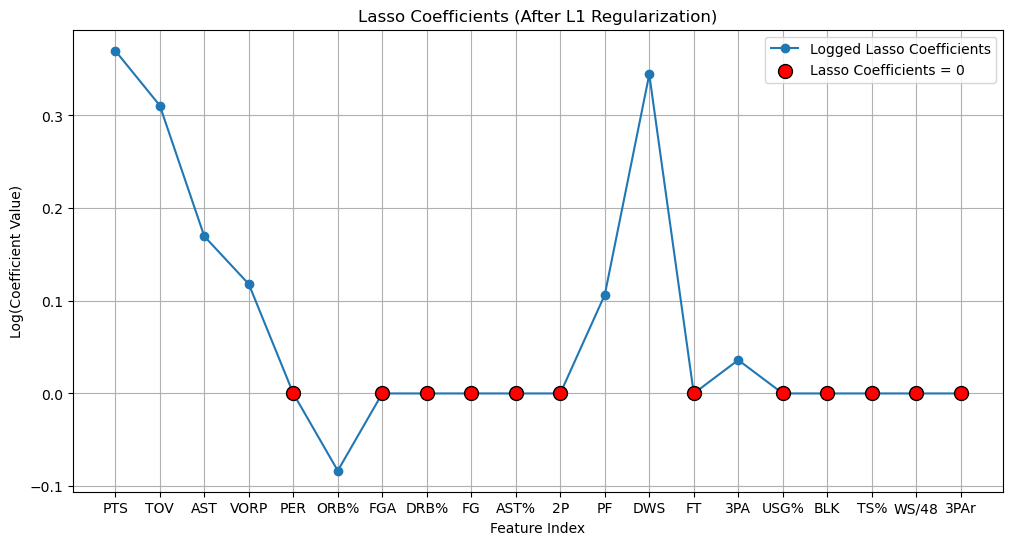

In [699]:
# Plot logged Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_df['Feature_Index'], coefficients_df['Lasso_Coefficients'], marker='o', label='Logged Lasso Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lasso Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Log(Coefficient Value)')
plt.title('Lasso Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()

## Is lassoLars more consistent

In [700]:
lassolars = LassoLarsCV(cv=5, max_iter=10000, n_jobs=-1)


lassolars.fit(X_train, y_train)

best_alpha = lassolars.alpha_
print("Optimal alpha:", best_alpha)


Optimal alpha: 0.01694376835576045


In [701]:
lars_coefficients = lassolars.coef_
lars_coefficients

array([ 0.37663649,  0.29596014,  0.17460969,  0.1169339 ,  0.        ,
       -0.0803956 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.09710097,  0.34213442,  0.        ,  0.03515366,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [702]:
# Print list of new coefficients of all features
lars_coefficients_df = pd.DataFrame({'Feature': X.columns, 'LassoLarsCV_Coefficient': lars_coefficients})
lars_coefficients_df

,Feature,LassoLarsCV_Coefficient
0,PTS,0.376636
1,TOV,0.295960
2,AST,0.174610
3,VORP,0.116934
4,PER,0.000000
5,ORB%,-0.080396
6,FGA,0.000000
7,DRB%,0.000000
8,FG,0.000000
9,AST%,0.000000


In [703]:
# Create a DataFrame to compare the coefficients
lars_coefficients_df = pd.DataFrame({
    'Feature_Index': (X.columns),
    'Lars_Coefficients': lars_coefficients
})

zero_indices = lars_coefficients_df[lars_coefficients_df['Lars_Coefficients'] == 0]['Feature_Index']

lars_coefficients_df

,Feature_Index,Lars_Coefficients
0,PTS,0.376636
1,TOV,0.295960
2,AST,0.174610
3,VORP,0.116934
4,PER,0.000000
5,ORB%,-0.080396
6,FGA,0.000000
7,DRB%,0.000000
8,FG,0.000000
9,AST%,0.000000


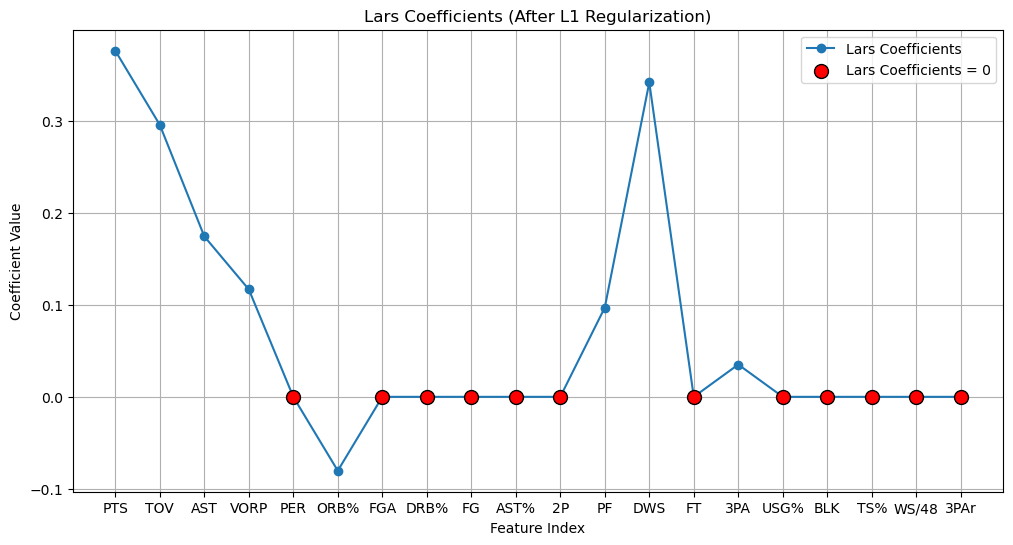

In [704]:
# Plot logged Lasso coefficients
plt.figure(figsize=(12, 6))
plt.plot(lars_coefficients_df['Feature_Index'], lars_coefficients_df['Lars_Coefficients'], marker='o', label='Lars Coefficients', linestyle='-')
#plt.xticks(coefficients_df['Feature_Index'])
plt.scatter(zero_indices, np.zeros(len(zero_indices)), color='red', edgecolor='black', s=100, zorder=5, label='Lars Coefficients = 0')
plt.xlabel('Feature Index')
plt.ylabel('Coefficient Value')
plt.title('Lars Coefficients (After L1 Regularization)')
plt.legend()
plt.grid(True)
plt.show()